In [ ]:
!pip cache purge
#!pip uninstall --yes sympy
#!pip uninstall --yes numpy
#!pip uninstall --yes protobuf
!pip install sympy
!pip install numpy==1.26.4
!pip install protobuf
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install pyngrok
!pip install opencv-python
!pip install scikit-learn
!pip install onnx==1.16.1
!pip install onnx2tf
!pip install wrapt
!pip install tf-keras
!pip install onnx-graphsurgeon
!pip install sng4onnx
!pip install  onnxruntime==1.20.1  


In [22]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
cuda = torch.cuda.is_available()

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn đến thư mục dataset
dataset_path = "E:/banana_classification"

# Kích thước ảnh và batch size
image_size = (32, 32)
batch_size = 32

# Định nghĩa các phép biến đổi chung
base_transform = transforms.Compose([
    transforms.Resize(image_size),          # Resize ảnh về kích thước 224x224
    transforms.ToTensor(),                  # Chuyển đổi ảnh thành Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Chuẩn hóa với giá trị mean/std
                         std=[0.229, 0.224, 0.225])
])

# Định nghĩa augmentation (nếu cần)
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Lật ngang với xác suất 50%
    transforms.RandomRotation(degrees=10)   # Xoay ngẫu nhiên trong khoảng [-10, 10] độ
])

# Tạo hàm lấy đường dẫn dữ liệu
class DataPathLoader:
    def __init__(self, root_dir):
        self.root_dir = root_dir

    def get_data_path(self, folder_name):
        return os.path.join(self.root_dir, folder_name)

# Khởi tạo DataPathLoader
path_loader = DataPathLoader(dataset_path)

# Tạo dataset cho train, validation và test
train_ds = datasets.ImageFolder(path_loader.get_data_path("train"), transform=base_transform)
val_ds = datasets.ImageFolder(path_loader.get_data_path("valid"), transform=base_transform)
test_ds = datasets.ImageFolder(path_loader.get_data_path("test"), transform=base_transform)

# Tạo DataLoader cho train, validation và test
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Kiểm tra cấu trúc dataset
print(f"Train dataset size: {len(train_ds)} samples")
print(f"Validation dataset size: {len(val_ds)} samples")
print(f"Test dataset size: {len(test_ds)} samples")

# Hàm hiển thị ảnh
def show_images(dataset_loader, class_names):
    plt.figure(figsize=(10, 10))
    images, labels = next(iter(dataset_loader))  # Lấy batch đầu tiên
    for i in range(9):  # Hiển thị 9 ảnh đầu tiên
        ax = plt.subplot(3, 3, i + 1)
        # Chuyển đổi ảnh từ Tensor sang định dạng hiển thị
        img = images[i].permute(1, 2, 0).numpy()  # Chuyển từ (C, H, W) sang (H, W, C)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Bỏ chuẩn hóa
        img = np.clip(img, 0, 1)  # Giới hạn giá trị trong khoảng [0, 1]
        plt.imshow(img)
        plt.title(class_names[labels[i].item()])
        plt.axis("off")
    plt.show()

# In danh sách tên các lớp
class_names = train_ds.classes
print("Class names:", class_names)

# Hiển thị ảnh từ train_loader
show_images(train_loader, class_names)


In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCustomModel(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=3):
        super(SimpleCustomModel, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)  # 3x32x32 -> 6x32x32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 6x32x32 -> 6x16x16
        
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)  # 6x16x16 -> 16x12x12
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 16x12x12 -> 16x6x6

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),  # 16x6x6 -> 576
            nn.Linear(16 * 6 * 6, 120),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(120, 84),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(84, num_classes)  # Output layer
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.fc(x)
        return F.softmax(x, dim=1)

# Create the model
model = SimpleCustomModel(input_shape=(3, 32, 32), num_classes=3)

# Print the model summary
print(model)


SimpleCustomModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=576, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=3, bias=True)
  )
)


Using device: cuda
SimpleCustomModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=576, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=3, bias=True)
  )
)


Epoch 1 - Training: 100%|██████████| 251/251 [00:15<00:00, 15.80it/s]


Train Loss: 0.7229, Train Accuracy: 0.83%


Epoch 1 - Testing: 100%|██████████| 12/12 [00:00<00:00, 21.46it/s]


Test Loss: 0.6513, Test Accuracy: 0.91%


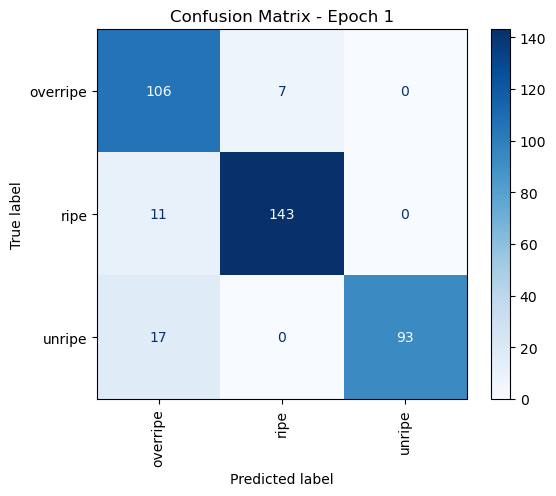

Epoch 2 - Training: 100%|██████████| 251/251 [00:15<00:00, 16.26it/s]


Train Loss: 0.6277, Train Accuracy: 0.92%


Epoch 2 - Testing: 100%|██████████| 12/12 [00:00<00:00, 20.79it/s]


Test Loss: 0.6381, Test Accuracy: 0.91%


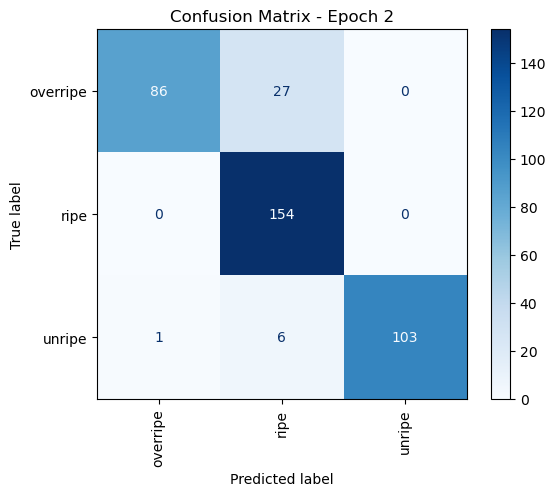

Epoch 3 - Training: 100%|██████████| 251/251 [00:17<00:00, 14.35it/s]


Train Loss: 0.6047, Train Accuracy: 0.95%


Epoch 3 - Testing: 100%|██████████| 12/12 [00:00<00:00, 16.53it/s]


Test Loss: 0.5928, Test Accuracy: 0.96%


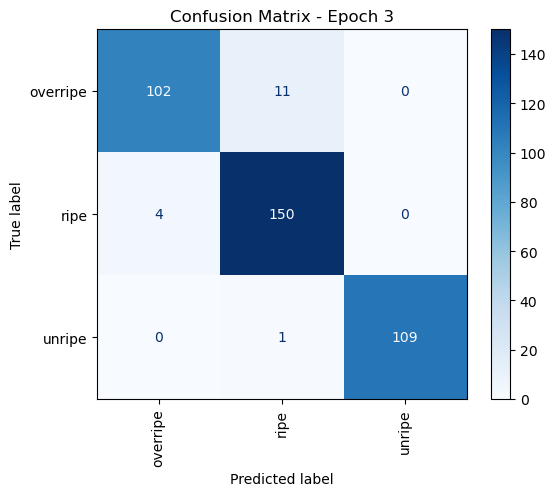

Epoch 4 - Training: 100%|██████████| 251/251 [00:16<00:00, 15.43it/s]


Train Loss: 0.6139, Train Accuracy: 0.94%


Epoch 4 - Testing: 100%|██████████| 12/12 [00:00<00:00, 18.88it/s]


Test Loss: 0.5989, Test Accuracy: 0.95%


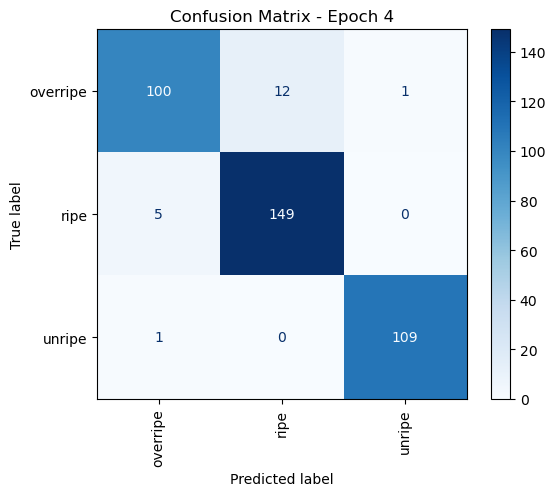

Epoch 5 - Training: 100%|██████████| 251/251 [00:16<00:00, 15.24it/s]


Train Loss: 0.5973, Train Accuracy: 0.95%


Epoch 5 - Testing: 100%|██████████| 12/12 [00:00<00:00, 16.63it/s]


Test Loss: 0.6044, Test Accuracy: 0.94%


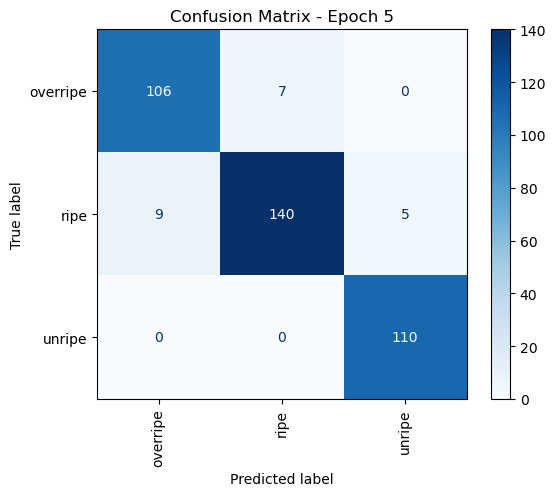

Epoch 6 - Training: 100%|██████████| 251/251 [00:16<00:00, 15.53it/s]


Train Loss: 0.6011, Train Accuracy: 0.95%


Epoch 6 - Testing: 100%|██████████| 12/12 [00:00<00:00, 20.72it/s]


Test Loss: 0.6020, Test Accuracy: 0.95%


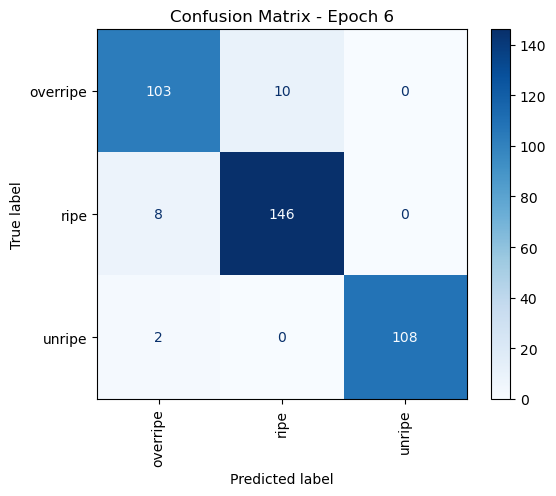

Epoch 7 - Training: 100%|██████████| 251/251 [00:16<00:00, 15.01it/s]


Train Loss: 0.5943, Train Accuracy: 0.96%


Epoch 7 - Testing: 100%|██████████| 12/12 [00:00<00:00, 18.06it/s]


Test Loss: 0.5913, Test Accuracy: 0.96%


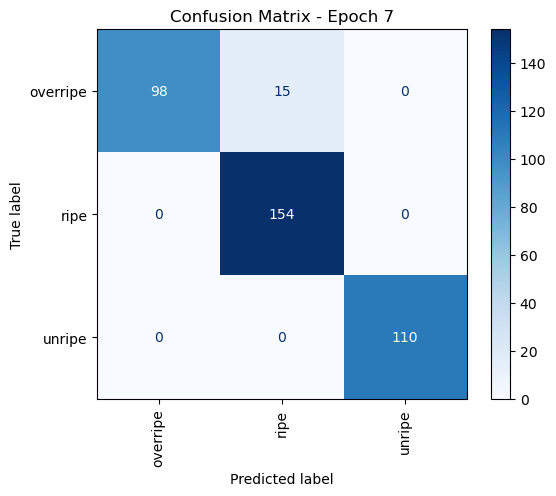

Epoch 8 - Training: 100%|██████████| 251/251 [00:18<00:00, 13.87it/s]


Train Loss: 0.5935, Train Accuracy: 0.96%


Epoch 8 - Testing: 100%|██████████| 12/12 [00:00<00:00, 19.56it/s]

Test Loss: 0.6090, Test Accuracy: 0.94%


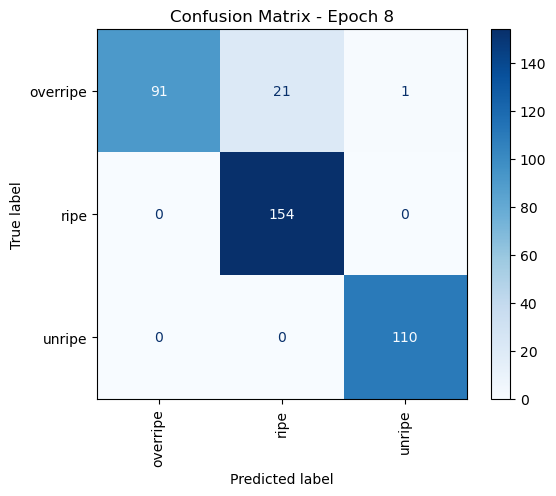

Epoch 9 - Training: 100%|██████████| 251/251 [00:17<00:00, 14.43it/s]


Train Loss: 0.5946, Train Accuracy: 0.96%


Epoch 9 - Testing: 100%|██████████| 12/12 [00:00<00:00, 16.78it/s]


Test Loss: 0.5897, Test Accuracy: 0.96%


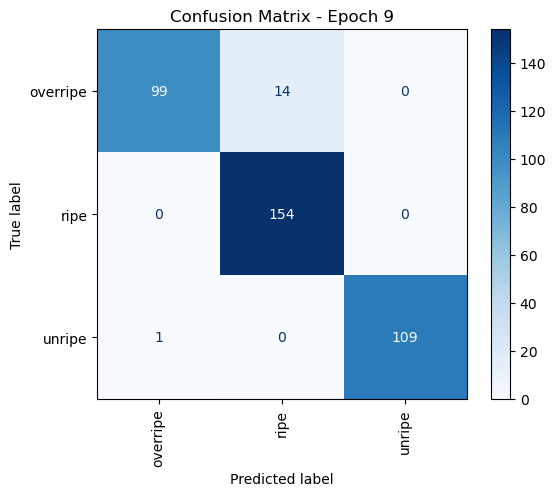

Epoch 10 - Training: 100%|██████████| 251/251 [00:16<00:00, 15.68it/s]


Train Loss: 0.5957, Train Accuracy: 0.96%


Epoch 10 - Testing: 100%|██████████| 12/12 [00:00<00:00, 21.86it/s]


Test Loss: 0.6023, Test Accuracy: 0.95%


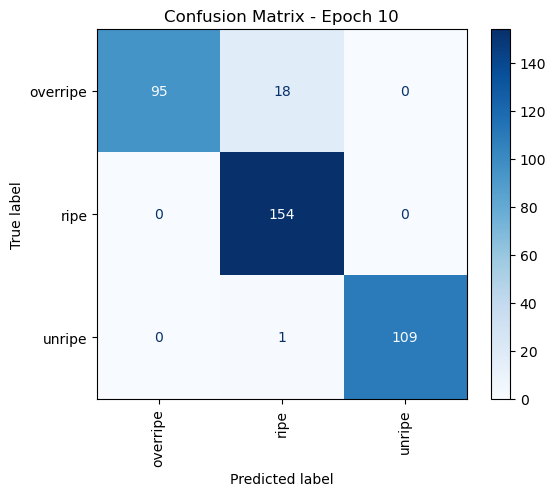

Model saved to simple_custom_model.pth


In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Đảm bảo sử dụng GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Vẽ confusion matrix
def plot_confusion_matrix(labels, preds, classes, epoch):
    cm = confusion_matrix(labels, preds, labels=np.arange(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - Epoch {epoch + 1}")
    plt.show()

# Hàm huấn luyện
def train(train_loader, model, criterion, optimizer, epoch, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    return train_loss, train_accuracy

# Hàm đánh giá

def evaluate(test_loader, model, criterion, epoch, device, class_names):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch + 1} - Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    plot_confusion_matrix(all_labels, all_preds, class_names, epoch)
    return test_loss, test_accuracy

# Tên các lớp
class_names = ["overripe", "ripe", "unripe"]  # Thay bằng tên lớp của bạn

# Khởi tạo mô hình
model = SimpleCustomModel(input_shape=(3, 32, 32), num_classes=len(class_names)).to(device)
print(model)

# Khởi tạo loss function và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
num_epochs = 10
train_history = {"loss": [], "accuracy": []}
test_history = {"loss": [], "accuracy": []}

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(train_loader, model, criterion, optimizer, epoch, device)
    test_loss, test_accuracy = evaluate(test_loader, model, criterion, epoch, device, class_names)

    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_accuracy)
    test_history["loss"].append(test_loss)
    test_history["accuracy"].append(test_accuracy)

# Lưu mô hình
torch.save(model.state_dict(), "simple_custom_model.pth")
print("Model saved to simple_custom_model.pth")


In [113]:
# Đảm bảo sử dụng CPU cho cả mô hình và đầu vào
device = torch.device("cpu")

# Tạo dummy input trên CPU
dummy_input = torch.randn(1, 3, 32, 32, dtype=torch.float32, device=device)

# Chuyển mô hình về CPU
model = model.to(device)

# Xuất mô hình sang ONNX
torch.onnx.export(
    model=model,
    args=dummy_input,
    f="simple_custom_model.onnx",
    verbose=True,
    export_params=True,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    opset_version=11
)
print("ONNX model successfully converted")


ONNX model successfully converted


In [116]:
!onnx2tf -i simple_custom_model.onnx  -v info


Model optimizing started ============================================================
Traceback (most recent call last):
  File "C:\Users\ChuPhu\anaconda3\Lib\site-packages\onnx2tf\onnx2tf.py", line 645, in convert
    result = subprocess.check_output(
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ChuPhu\anaconda3\Lib\subprocess.py", line 466, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ChuPhu\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ChuPhu\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ChuPhu\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^


I0000 00:00:1735340662.157237   28888 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1735340662.157448   28888 single_machine.cc:361] Starting new session
W0000 00:00:1735340662.198244   28888 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1735340662.198364   28888 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1735340662.250626   28888 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1735340662.250827   28888 single_machine.cc:361] Starting new session
W0000 00:00:1735340662.286490   28888 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1735340662.286552   28888 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


  Using cached onnx-simplifier-0.4.36.tar.gz (21.0 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Discarding https://files.pythonhosted.org/packages/6a/95/9d93b8cfdd9f57abe7000cd6b9e56e2c518ce0e6bf6b312b1cf37b4e68a8/onnx-simplifier-0.4.36.tar.gz (from https://pypi.org/simple/onnx-simplifier/) (requires-python:>=3.7): Requested onnxsim from https://files.pythonhosted.org/packages/6a/95/9d93b8cfdd9f57abe7000cd6b9e56e2c518ce0e6bf6b312b1cf37b4e68a8/onnx-simplifier-0.4.36.tar.gz has inconsistent name: expected 'onnx-simplifier', but metadata has 'onnxsim'
  Using cached onnx-simplifier-0.4.35.tar.gz (20.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Discarding https://files.pythonhosted.org/packages/a5/65/56398c020ea361a879968d8f703ccf34fcb4ad172eff17b132f6948271ad/onnx-simplifier-0.4.35.tar.gz (from https://pypi.org/simple/onnx-simplifier/) (requires-python:>=3.7): Reques

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      C:\Users\ChuPhu\AppData\Local\Temp\pip-install-dwgkibz4\onnx-simplifier_956b1b7bb8074bc59511f176f7a45f0e\setup.py:26: DeprecationWarning: Use shutil.which instead of find_executable
        CMAKE = find_executable('cmake')
      fatal: not a git repository (or any of the parent directories): .git
      fatal: not a git repository (or any of the parent directories): .git
      C:\Users\ChuPhu\anaconda3\Lib\site-packages\setuptools\__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ****************************************************